# Prediccion de volatibilidad del BITCOIN usando series de tiempo


In [2]:
import pandas as pd
btc = pd.read_csv('btc_1d_data_2018_to_2025.csv')
btc

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844,2018-01-01 23:59:59.999,1.147997e+08,105595,3961.938946,5.280975e+07,0
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,1.580801e+08,0
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,1.335873e+08,0
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,1.861168e+08,0
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,2.118299e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2589,2025-02-02,100635.66,101456.60,99747.59,99796.00,3149.622330,2025-02-02 23:59:59.999,3.167280e+08,558753,1223.084700,1.231618e+08,0
2590,2025-02-03,97700.59,97782.79,91231.00,94495.21,20992.955720,2025-02-03 23:59:59.999,1.983835e+09,2309956,9239.171560,8.738586e+08,0
2591,2025-02-04,101328.51,101660.94,100743.33,101367.77,1910.355420,2025-02-04 23:59:59.999,1.933988e+08,208849,822.417140,8.326802e+07,0
2592,2025-02-05,97763.14,98930.44,97131.43,97589.30,8160.567950,2025-02-05 23:59:59.999,7.990502e+08,1597813,3672.410530,3.596230e+08,0


In [3]:
import pandas as pd
btc = btc[['Close time', 'Close']].dropna().reset_index(drop=True)
btc

,Close time,Close
0,2018-01-01 23:59:59.999,13380.00
1,2018-01-02 23:59:59.999,14675.11
2,2018-01-03 23:59:59.999,14919.51
3,2018-01-04 23:59:59.999,15059.54
4,2018-01-05 23:59:59.999,16960.39
...,...,...
2589,2025-02-02 23:59:59.999,99796.00
2590,2025-02-03 23:59:59.999,94495.21
2591,2025-02-04 23:59:59.999,101367.77
2592,2025-02-05 23:59:59.999,97589.30


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


In [5]:
btc = btc.rename(columns={"Close time": "Date"})
btc["Date"] = pd.to_datetime(btc["Date"])
btc = btc.sort_values("Date").reset_index(drop=True)


# Conceptos clave en series financieras

## 1. Retornos logarítmicos

En lugar de trabajar directamente con los precios, en finanzas se utilizan **retornos** para medir las variaciones de un activo.  
Existen dos formas principales:

- **Retorno simple:**

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

- **Retorno logarítmico:**

$$
r_t = \ln \left( \frac{P_t}{P_{t-1}} \right)
$$

### ✅ Ventajas de los retornos logarítmicos
1. **Aditividad en el tiempo**: los retornos logarítmicos se pueden sumar para obtener el retorno total de varios períodos:

$$
r_{total} = \ln\left(\frac{P_t}{P_0}\right) = \sum_{i=1}^t r_i
$$

2. **Simetría**: corrige la asimetría que aparece con los retornos simples (ej. +10% seguido de -10%).  
3. **Mejor ajuste estadístico**: suelen aproximarse mejor a distribuciones normales.  
4. **Escalabilidad**: funcionan igual para datos diarios, semanales o mensuales.

---

## 2. Volatilidad histórica

La **volatilidad** mide la dispersión de los retornos en un período de tiempo.  
Se calcula como la desviación estándar de los retornos logarítmicos en una ventana de tamaño \( n \):

$$
\sigma_t = \sqrt{\frac{1}{n-1} \sum_{i=1}^n (r_{t-i} - \bar{r})^2}
$$

donde:

- $r_{t-i}$ → retorno logarítmico del día $t-i$
- $ \bar{r} $ → media de los retornos en la ventana  
- $n$ → número de días en la ventana


Para comparabilidad se suele **anualizar** la volatilidad multiplicando por la raíz del número de períodos en un año:

$$
\sigma_{anual} = \sigma_{ventana} \cdot \sqrt{252}
$$

(252 ≈ número de días de trading al año).

---

### 🔍 Elección de la ventana
- **Ventanas cortas (7–14 días):** capturan cambios recientes, muy sensibles al ruido.  
- **Ventanas medianas (21–30 días):** equilibrio entre sensibilidad y estabilidad.  
- **Ventanas largas (60–90+ días):** suavizan mucho las fluctuaciones, útiles para tendencias de largo plazo.

---


In [6]:
# Retornos logarítmicos
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))

# Volatilidad histórica (rolling std * sqrt(365)), ventana de 30 días
WINDOW_VOL = 30
btc["Volatility_30d"] = (
    btc["LogReturn"].rolling(window=WINDOW_VOL).std() * np.sqrt(365)
)


In [7]:
# Ver si hay valores nulos en el DataFrame
print(btc.isnull().sum())

# O ver el total de nulos
print("\nTotal de nulos en todo el dataset:", btc.isnull().sum().sum())


Date               0
Close              0
LogReturn          1
Volatility_30d    30
dtype: int64

Total de nulos en todo el dataset: 31


In [8]:
print("\n=== Descriptivas: Precio (Close) ===")
print(btc["Close"].describe())

print("\n=== Descriptivas: Retornos log (LogReturn) ===")
print(btc["LogReturn"].describe())

print("\n=== Descriptivas: Volatilidad 30d anualizada ===")
print(btc["Volatility_30d"].describe())



=== Descriptivas: Precio (Close) ===
count      2594.000000
mean      29090.193446
std       23576.229505
min        3211.720000
25%        9068.840000
50%       22741.115000
75%       43527.390000
max      106143.820000
Name: Close, dtype: float64

=== Descriptivas: Retornos log (LogReturn) ===
count    2593.000000
mean        0.000769
std         0.036221
min        -0.502607
25%        -0.014171
50%         0.000708
75%         0.016304
max         0.178449
Name: LogReturn, dtype: float64

=== Descriptivas: Volatilidad 30d anualizada ===
count    2564.000000
mean        0.630397
std         0.268976
min         0.167561
25%         0.464059
50%         0.580054
75%         0.740492
max         2.117772
Name: Volatility_30d, dtype: float64


# 📊 Análisis descriptivo inicial de BTC

## 1. Precio de cierre (Close)
- **Media ≈ 29,090 USD** → precio promedio en todo el período (2018–2025).  
- **Desviación estándar ≈ 23,576 USD** → los precios muestran una alta dispersión, típico de un activo riesgoso como BTC.  
- **Mínimo ≈ 3,211 USD** → corresponde al piso histórico en 2018–2019.  
- **Máximo ≈ 106,143 USD** → refleja los picos de mercado de 2021 y 2024–2025.  
- **Mediana ≈ 22,741 USD**, menor a la media → la distribución está sesgada por los valores muy altos.  

➡️ **Conclusión:** el precio de BTC **no es estable**, presenta ciclos de subidas y caídas abruptas.

---

## 2. Retornos logarítmicos (LogReturn)
- **Media ≈ 0.00077 (~0.077%)** → retornos diarios tienden a cero, como es habitual en activos financieros.  
- **Desviación estándar ≈ 0.036 (3.6%)** → en promedio, BTC se mueve entre 3–4% al día.  
- **Mínimo ≈ –0.50 (–50%)** y **máximo ≈ +0.18 (+18%)** → se observan eventos extremos (crashes y rallies).  
- **Mediana ≈ 0.0007** → la mayoría de días presentan movimientos pequeños, aunque las colas pesadas dominan la volatilidad.  

➡️ **Conclusión:** los retornos están **centrados en 0** pero muestran colas pesadas, evidencia de **alta volatilidad y no-normalidad**.

---

## 3. Volatilidad 30d anualizada
- **Media ≈ 0.63 (63%)** → BTC tuvo en promedio una volatilidad anual del 63%, muy superior a activos tradicionales (bolsa ≈ 15–20%).  
- **Desviación estándar ≈ 0.27** → la volatilidad misma cambia bastante en el tiempo.  
- **Mínimo ≈ 0.16 (16%)**, **máximo ≈ 2.11 (211%)** → en momentos extremos, la volatilidad anualizada superó el 200%.  
- **Mediana ≈ 0.58 (58%)** → más representativa de la “normalidad” que la media.  

➡️ **Conclusión:** BTC es un activo **ultra-volátil**, con períodos relativamente tranquilos pero también fases de riesgo extremo.

---

## 📌 Síntesis general
- El precio de BTC muestra una **tendencia creciente con ciclos de burbujas**.  
- Los retornos están centrados en 0, pero tienen **colas pesadas y distribuciones no normales**.  
- La volatilidad es **estructuralmente alta y variable en el tiempo**, confirmando la **heterocedasticidad**.  


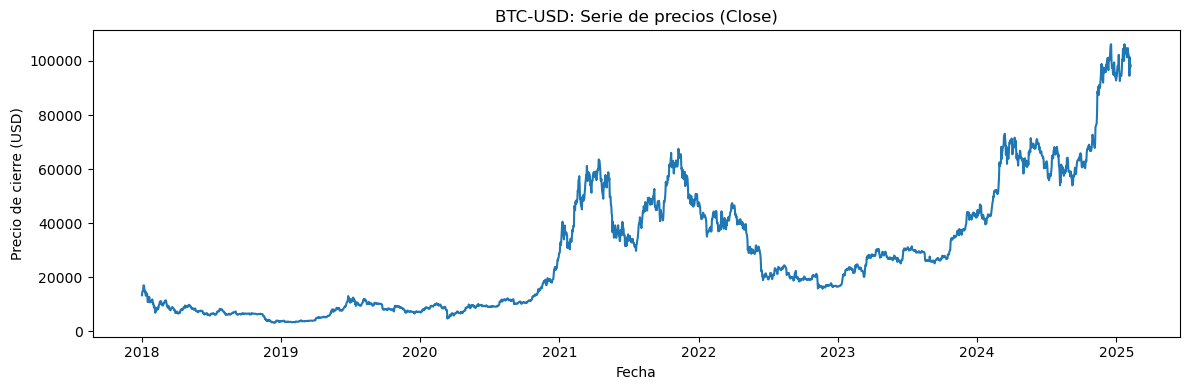

In [9]:
# Visualizacion
# (a) Serie temporal de precios
plt.figure(figsize=(12,4))
plt.plot(btc["Date"], btc["Close"])
plt.title("BTC-USD: Serie de precios (Close)")
plt.xlabel("Fecha"); plt.ylabel("Precio de cierre (USD)")
plt.tight_layout()
plt.show()


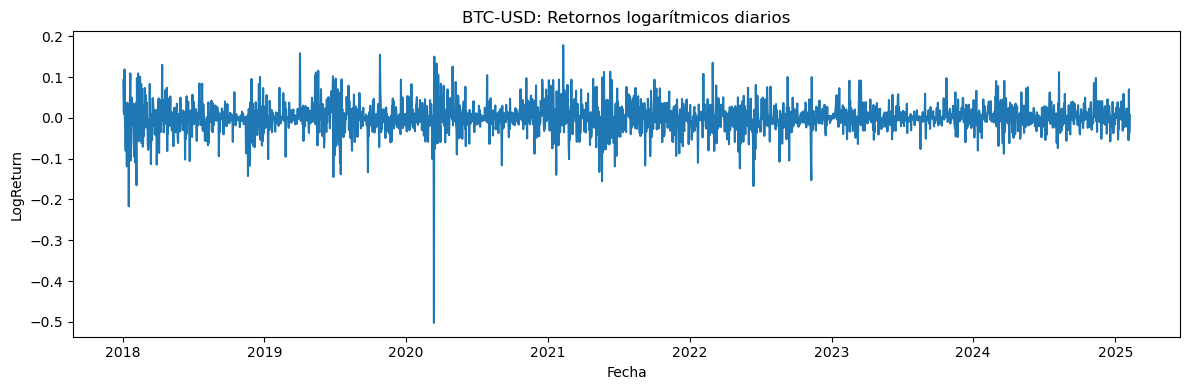

In [10]:
# (b) Serie de retornos logarítmicos
plt.figure(figsize=(12,4))
plt.plot(btc["Date"], btc["LogReturn"])
plt.title("BTC-USD: Retornos logarítmicos diarios")
plt.xlabel("Fecha"); plt.ylabel("LogReturn")
plt.tight_layout()
plt.show()

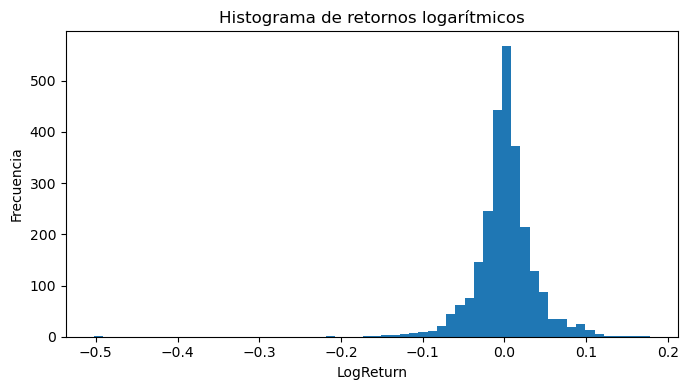

In [11]:
# (c) Histograma de retornos
plt.figure(figsize=(7,4))
plt.hist(btc["LogReturn"], bins=60)
plt.title("Histograma de retornos logarítmicos")
plt.xlabel("LogReturn"); plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

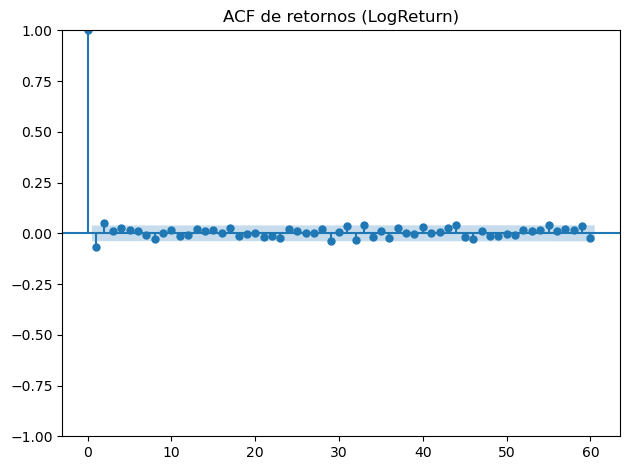

<Figure size 800x400 with 0 Axes>

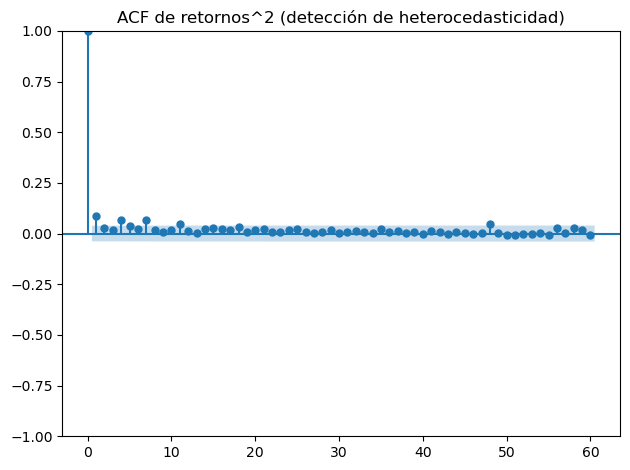

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import matplotlib.pyplot as plt

# Asegurar que no haya NaN
log_ret = btc["LogReturn"].dropna()

# (d) ACF de retornos
plt.figure(figsize=(8,4))
plot_acf(log_ret, lags=60)
plt.title("ACF de retornos (LogReturn)")
plt.tight_layout()
plt.show()

# (e) ACF de retornos^2 (heterocedasticidad)
plt.figure(figsize=(8,4))
plot_acf(np.square(log_ret), lags=60)
plt.title("ACF de retornos^2 (detección de heterocedasticidad)")
plt.tight_layout()
plt.show()


# 📊 Análisis de gráficos exploratorios de BTC

## 1️⃣ Serie de precios (Close)
**Qué muestra:** evolución del precio de BTC entre 2018 y 2025.  

- Se observan **picos pronunciados** en 2021 y 2024, seguidos de caídas.  
- El precio pasó de valores cercanos a **3,000 USD** en 2018 hasta superar los **100,000 USD** en 2025.  

**Conclusión:** BTC es un activo con tendencia creciente pero con **ciclos de burbuja y colapso muy claros**.  

---

## 2️⃣ Retornos logarítmicos diarios
**Qué muestra:** variación diaria del precio.  

- La mayoría de retornos están cercanos a **0**.  
- Aparecen **picos extremos negativos** (caídas bruscas) y algunos positivos (rallies).  
- Ejemplo: en 2020 se observa un crash fuerte (posiblemente el efecto del COVID en marzo).  

**Conclusión:** retornos con distribución centrada en cero pero con **eventos extremos (colas pesadas)**.  

---

## 3️⃣ Histograma de retornos logarítmicos
**Qué muestra:** distribución de los retornos diarios.  

- La mayoría de días presentan cambios entre **–5% y +5%**.  
- La forma es **campana centrada en 0**, pero más “picuda” y con colas más largas que una normal.  

**Conclusión:** los retornos **no siguen una normal perfecta**, sino que tienen **kurtosis alta** (más probabilidad de eventos extremos).  

---

## 4️⃣ ACF de retornos (LogReturn)
**Qué muestra:** autocorrelación de los retornos hasta 60 rezagos (≈ 2 meses).  

- Casi todas las barras están **dentro de las bandas azules**.  
- No hay dependencia lineal significativa entre retornos pasados y futuros.  

**Conclusión:** los retornos se comportan como **ruido blanco**, consistente con la hipótesis de **mercados eficientes**.  

---

## 5️⃣ ACF de retornos² (heterocedasticidad)
**Qué muestra:** autocorrelación de los retornos al cuadrado (proxy de la volatilidad).  

- Varias barras **sobresalen al inicio**, lo que indica dependencia en la varianza.  
- Esto significa que la volatilidad tiende a **agruparse en clusters**: periodos de alta volatilidad seguidos de alta, y baja seguidos de baja.  

**Conclusión:** existe **heterocedasticidad** → justifica el uso de modelos como **ARCH/GARCH** o **MLP con features de volatilidad**.  

---

## 📌 Síntesis general
- El precio de BTC muestra **ciclos de burbujas y crashes**.  
- Los retornos están centrados en 0 pero con **colas pesadas y no-normalidad**.  
- No hay autocorrelación en retornos → **ruido blanco**.  
- Sí hay autocorrelación en retornos² → **clustering de volatilidad**.  


In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# BDS: intentamos statsmodels; si no, arch
_BDS_BACKEND = None
try:
    from statsmodels.tsa.stattools import bds as bds_sm
    _BDS_BACKEND = "statsmodels"
except Exception:
    try:
        from arch.bootstrap import bds as bds_arch
        _BDS_BACKEND = "arch"
    except Exception:
        _BDS_BACKEND = None

# Intentar usar tsxv/timeseries-cv (como exige el enunciado)
_TSX_AVAILABLE = False
try:
    from tsxv import split_train_val_test_groupKFold as _split_tsxv  # pip install tsxv
    _TSX_AVAILABLE = True
except Exception:
    try:
        from timeseries_cv import split_train_val_test_groupKFold as _split_tsxv  # pip install timeseries-cv
        _TSX_AVAILABLE = True
    except Exception:
        _TSX_AVAILABLE = False

# Rutas de salida
FIGS_DIR = "notebooks/figs"
RESULTS_DIR = "results"
os.makedirs(FIGS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)


In [25]:
# Retornos log
btc["log_return"] = np.log(btc["Close"] / btc["Close"].shift(1))

# Limpia NaN inicial
btc = btc.dropna().reset_index(drop=True)

dates_full = btc["Date"].copy()
close_full = btc["Close"].values.astype(float)
ret_full   = btc["log_return"].values.astype(float)  # usaremos |ret| como proxy de volatilidad realizada


In [26]:
def build_supervised_from_close_for_volatility(close: np.ndarray,
                                               log_returns: np.ndarray,
                                               dates: pd.Series,
                                               n_steps_input: int,
                                               n_steps_forecast: int,
                                               n_steps_jump: int = 1):
    """
    Features X: últimos 'n_steps_input' CIERRES (Close).
    Target Y:  |retornos log| de los próximos 'n_steps_forecast' días (proxy de volatilidad realizada).
    Devuelve: X (N, n_steps_input), Y (N, n_steps_forecast), dates_samples (N,)
    El i-ésimo ejemplo usa close[t-n_steps_input+1 : t+1] y predice |r_{t+1 : t+n_steps_forecast}|.
    """
    assert len(close) == len(log_returns) == len(dates)
    X_list, Y_list, D_list = [], [], []
    T = len(close)

    # El último índice de input es t; el último índice de target es t + n_steps_forecast
    # Nos aseguramos de no pasarnos del final.
    for t in range(n_steps_input - 1, T - n_steps_forecast - 1, n_steps_jump):
        # ventana de input (closes)
        x = close[t - n_steps_input + 1 : t + 1]
        # futuros retornos (abs para proxy de volatilidad realizada)
        future_r = np.abs(log_returns[t + 1 : t + 1 + n_steps_forecast])
        if len(x) == n_steps_input and len(future_r) == n_steps_forecast:
            X_list.append(x)
            Y_list.append(future_r)
            D_list.append(dates.iloc[t])  # fecha asociada al final del input

    X = np.asarray(X_list)
    Y = np.asarray(Y_list)
    D = pd.to_datetime(pd.Series(D_list))
    return X, Y, D


def make_time_groups(dates: pd.Series, freq: str = "W"):
    """
    Agrupa muestras por periodo temporal (semana por defecto) para usar en GroupKFold.
    """
    period = pd.to_datetime(dates).dt.to_period(freq).astype(str)
    return pd.Categorical(period).codes


def _fallback_split_train_val_test_groupKFold(X, Y, dates, n_splits=5, val_size=0.5, freq_groups="W"):
    """
    Fallback simple: GroupKFold por bloques temporales.
    En cada fold, el 'holdout' (grupos no vistos) se divide cronológicamente en val/test (50/50 por defecto).
    """
    groups = make_time_groups(dates, freq=freq_groups)
    gkf = GroupKFold(n_splits=n_splits)

    splits = []
    for tr_idx, ho_idx in gkf.split(X, Y, groups=groups):
        tr_idx = np.sort(tr_idx)
        ho_idx = np.sort(ho_idx)

        # Orden cronológico dentro del holdout
        order = np.argsort(dates.iloc[ho_idx].values)
        ho_ord = ho_idx[order]
        n_hold = len(ho_ord)
        n_val = max(1, min(int(np.floor(val_size * n_hold)), n_hold - 1))

        va_idx = ho_ord[:n_val]
        te_idx = ho_ord[n_val:]

        splits.append({"train_idx": tr_idx, "val_idx": va_idx, "test_idx": te_idx})
    return splits


def split_train_val_test_groupKFold_wrapper(X, Y, dates, n_splits=5, val_size=0.5, freq_groups="W"):
    """
    Usa la función oficial si está disponible; si no, usa el fallback.
    """
    if _TSX_AVAILABLE:
        try:
            groups = make_time_groups(dates, freq=freq_groups)
            # algunas variantes aceptan val_size y shuffle=False
            return _split_tsxv(X=X, y=Y, groups=groups, n_splits=n_splits, val_size=val_size, shuffle=False)
        except TypeError:
            # si la firma difiere, caemos al fallback
            return _fallback_split_train_val_test_groupKFold(X, Y, dates, n_splits, val_size, freq_groups)
    else:
        return _fallback_split_train_val_test_groupKFold(X, Y, dates, n_splits, val_size, freq_groups)


In [27]:
def safe_mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom), axis=0)  # por horizonte

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=0)            # por horizonte

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2, axis=0)               # por horizonte

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))                        # por horizonte

def get_bds_pvalue(residuals_h1, max_dim=2, min_len=40):
    """
    Devuelve p-value del BDS sobre los residuos del horizonte 1.
    - Limpia NaN/Inf
    - Estandariza (z-score) para estabilidad numérica
    - Verifica longitud mínima y varianza > 0
    - Soporta statsmodels o arch, según disponibilidad
    """
    r = np.asarray(residuals_h1).astype(float)
    r = r[np.isfinite(r)]  # quita NaN/Inf

    if r.size < min_len:
        return np.nan  # muy corto: mejor reportar nan que un valor engañoso

    # Estandarizar
    mu, sd = np.mean(r), np.std(r, ddof=1)
    if sd == 0 or not np.isfinite(sd):
        return np.nan
    z = (r - mu) / sd

    # Llamar al backend disponible
    if _BDS_BACKEND == "statsmodels":
        try:
            res = bds_sm(z, max_dim=max_dim)   # -> BdsTestResult
            return float(getattr(res, "pvalue", np.nan))
        except Exception:
            return np.nan

    elif _BDS_BACKEND == "arch":
        try:
            res = bds_arch(z, max_dim=max_dim)  # -> DataFrame con filas por dimensión
            # Buscar la columna de p-value compatible
            pv_col = None
            for c in res.columns:
                if "p" in c.lower():
                    pv_col = c; break
            if pv_col is None:
                return np.nan
            # p-value para dimensión 2 (fila con índice 2 o posición 1)
            if 2 in getattr(res, "index", []):
                return float(res.loc[2, pv_col])
            else:
                return float(res.iloc[1][pv_col])
        except Exception:
            return np.nan
    else:
        return np.nan



In [23]:
!pip install statsmodels        # recomendado

In [28]:
# ===== Sección 5 (robusta): Lags → CV → MLP → Métricas → (opcional) Guardado =====

from pathlib import Path

# Flags para controlar guardado
SAVE_ARTIFACTS = True   # pon False si NO quieres guardar CSV/PNGs
FIGS_DIR = Path("notebooks/figs")
RESULTS_DIR = Path("results")

# Crear carpetas si se va a guardar
if SAVE_ARTIFACTS:
    FIGS_DIR.mkdir(parents=True, exist_ok=True)
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

lags_list = [7, 14, 21, 28]
n_steps_forecast = 7
n_steps_jump = 1

results_by_L = {}
metrics_rows_master = []

def _safe_savefig(path_obj):
    """Guardar figura sin romper si falla y cerrar."""
    try:
        import matplotlib.pyplot as plt
        plt.tight_layout()
        plt.savefig(path_obj, dpi=140)
        plt.close()
    except Exception as e:
        print(f"[WARN] No se pudo guardar figura en {path_obj}: {e}")

def _safe_to_csv(df, path_obj):
    """Guardar CSV sin romper si falla."""
    try:
        df.to_csv(path_obj, index=False)
    except Exception as e:
        print(f"[WARN] No se pudo guardar CSV en {path_obj}: {e}")

for L in lags_list:
    print(f"\n===== Usando {L} lags del precio → predecir |ret| futuros (h=1..7) =====")

    # 1) Dataset supervisado
    X, Y, D = build_supervised_from_close_for_volatility(
        close=close_full, log_returns=ret_full, dates=dates_full,
        n_steps_input=L, n_steps_forecast=n_steps_forecast, n_steps_jump=n_steps_jump
    )
    print(f"Shapes -> X: {X.shape}, Y: {Y.shape}, D: {len(D)}")

    # 2) Splits temporales
    splits = split_train_val_test_groupKFold_wrapper(
        X=X, Y=Y, dates=D, n_splits=5, val_size=0.5, freq_groups="W"
    )
    print(f"Folds: {len(splits)}")

    fold_metrics = []
    rmse_folds = []
    bds_pvals = []
    y_test_list = []
    y_pred_list = []

    for k, sp in enumerate(splits, start=1):
        tr, va, te = sp["train_idx"], sp["val_idx"], sp["test_idx"]
        X_tr, X_va, X_te = X[tr], X[va], X[te]
        Y_tr, Y_va, Y_te = Y[tr], Y[va], Y[te]

        # Escalado sin leakage
        sx = StandardScaler().fit(X_tr)
        sy = StandardScaler().fit(Y_tr)
        X_tr_s, X_va_s, X_te_s = sx.transform(X_tr), sx.transform(X_va), sx.transform(X_te)
        Y_tr_s, Y_va_s, Y_te_s = sy.transform(Y_tr), sy.transform(Y_va), sy.transform(Y_te)

        # Modelo
        model = MLPRegressor(hidden_layer_sizes=(64, 32), activation="relu",
                             max_iter=300, random_state=42 + k)
        model.fit(X_tr_s, Y_tr_s)

        # Predicciones TEST (des-escala)
        Yhat_te_s = model.predict(X_te_s)
        Yhat_te = sy.inverse_transform(Yhat_te_s)
        Y_te_real = Y_te

        # Métricas por horizonte y promedios
        mape_h = safe_mape(Y_te_real, Yhat_te)
        mae_h  = mae(Y_te_real, Yhat_te)
        mse_h  = mse(Y_te_real, Yhat_te)
        rmse_h = rmse(Y_te_real, Yhat_te)

        mape_avg = float(np.mean(mape_h))
        mae_avg  = float(np.mean(mae_h))
        mse_avg  = float(np.mean(mse_h))
        rmse_avg = float(np.mean(rmse_h))

        # BDS en h1
        resid_h1 = Y_te_real[:, 0] - Yhat_te[:, 0]
        bds_p = float(get_bds_pvalue(resid_h1))

        fold_row = {
            "L": L, "fold": k,
            **{f"MAPE_h{h+1}": mape_h[h] for h in range(n_steps_forecast)},
            **{f"MAE_h{h+1}":  mae_h[h]  for h in range(n_steps_forecast)},
            **{f"MSE_h{h+1}":  mse_h[h]  for h in range(n_steps_forecast)},
            **{f"RMSE_h{h+1}": rmse_h[h] for h in range(n_steps_forecast)},
            "MAPE_avg": mape_avg, "MAE_avg": mae_avg, "MSE_avg": mse_avg, "RMSE_avg": rmse_avg,
            "BDS_pvalue_h1": bds_p
        }
        fold_metrics.append(fold_row)
        rmse_folds.append(rmse_avg)
        bds_pvals.append(bds_p)

        y_test_list.append(Y_te_real)
        y_pred_list.append(Yhat_te)

    # DataFrame por L
    df_metrics = pd.DataFrame(fold_metrics)

    # Guardar CSV por L (si aplica)
    if SAVE_ARTIFACTS:
        _safe_to_csv(df_metrics, RESULTS_DIR / f"metrics_test_L{L}.csv")

    # Gráficas por L (si aplica)
    if SAVE_ARTIFACTS:
        # RMSE por fold
        plt.figure(figsize=(8,3.5))
        plt.bar(range(1, len(rmse_folds)+1), rmse_folds)
        plt.title(f"RMSE promedio (7-step) TEST por fold — L={L}")
        plt.xlabel("Fold"); plt.ylabel("RMSE promedio")
        _safe_savefig(FIGS_DIR / f"rmse_folds_L{L}.png")

        # RMSE medio por horizonte
        rmse_cols = [c for c in df_metrics.columns if c.startswith("RMSE_h")]
        rmse_h_mean = df_metrics[rmse_cols].mean(axis=0).values
        plt.figure(figsize=(8,3.5))
        plt.plot(range(1, n_steps_forecast+1), rmse_h_mean, marker="o")
        plt.title(f"RMSE medio por horizonte (TEST) — L={L}")
        plt.xlabel("Horizonte (días)"); plt.ylabel("RMSE")
        plt.xticks(range(1, n_steps_forecast+1))
        _safe_savefig(FIGS_DIR / f"rmse_hmean_L{L}.png")

    # Almacenar en memoria para diagnóstico/tabla maestra
    results_by_L[L] = {
        "df_metrics": df_metrics,
        "rmse_folds": rmse_folds,
        "bds_pvals": bds_pvals,
        "y_test_list": y_test_list,
        "y_pred_list": y_pred_list
    }

    # Acumular resumen para tabla maestra
    metrics_rows_master.append({
        "L": L,
        "MAPE_avg_mean": df_metrics["MAPE_avg"].mean(), "MAPE_avg_std": df_metrics["MAPE_avg"].std(),
        "MAE_avg_mean":  df_metrics["MAE_avg"].mean(),  "MAE_avg_std":  df_metrics["MAE_avg"].std(),
        "MSE_avg_mean":  df_metrics["MSE_avg"].mean(),  "MSE_avg_std":  df_metrics["MSE_avg"].std(),
        "RMSE_avg_mean": df_metrics["RMSE_avg"].mean(), "RMSE_avg_std": df_metrics["RMSE_avg"].std(),
        "BDS_pvalue_h1_mean": df_metrics["BDS_pvalue_h1"].mean()
    })

print("✔️ Sección 5 completada sin errores. (Guardado:", SAVE_ARTIFACTS, ")")



===== Usando 7 lags del precio → predecir |ret| futuros (h=1..7) =====
Shapes -> X: (2549, 7), Y: (2549, 7), D: 2549
Folds: 5

===== Usando 14 lags del precio → predecir |ret| futuros (h=1..7) =====
Shapes -> X: (2542, 14), Y: (2542, 7), D: 2542
Folds: 5

===== Usando 21 lags del precio → predecir |ret| futuros (h=1..7) =====
Shapes -> X: (2535, 21), Y: (2535, 7), D: 2535
Folds: 5

===== Usando 28 lags del precio → predecir |ret| futuros (h=1..7) =====
Shapes -> X: (2528, 28), Y: (2528, 7), D: 2528
Folds: 5
✔️ Sección 5 completada sin errores. (Guardado: True )


✔️ Diagnóstico de residuos (gráficas) generado para el primer fold de cada L.


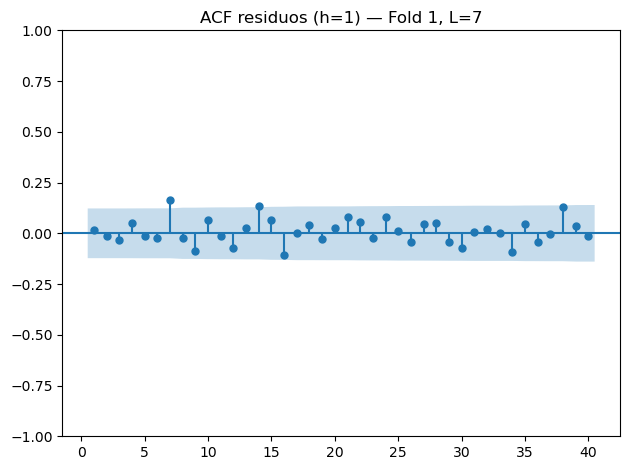

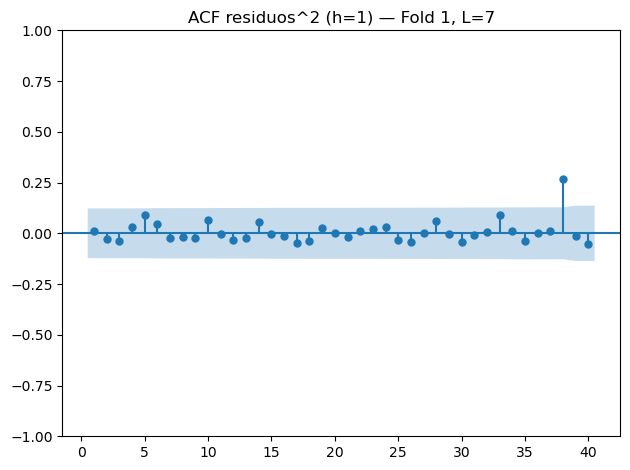

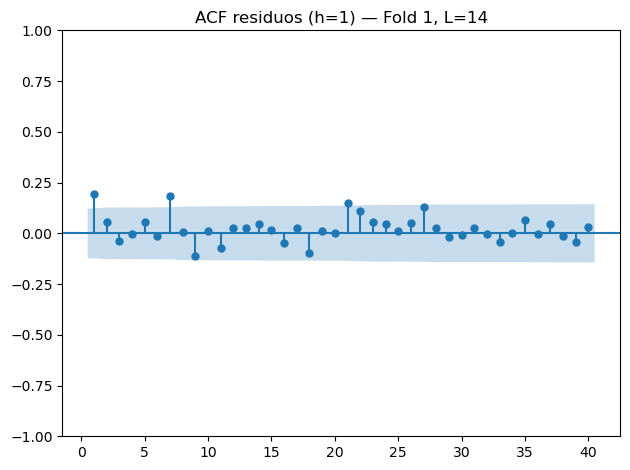

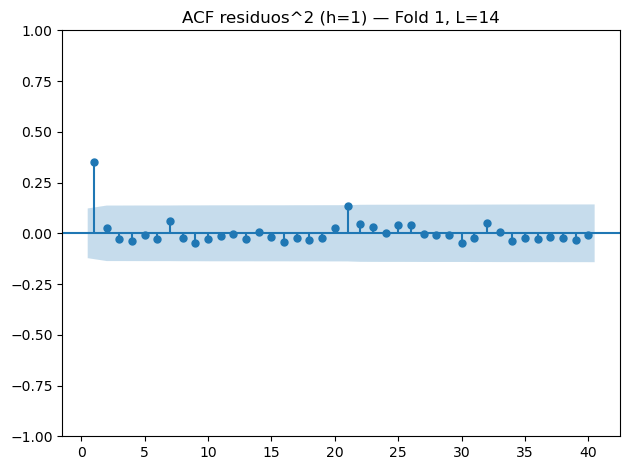

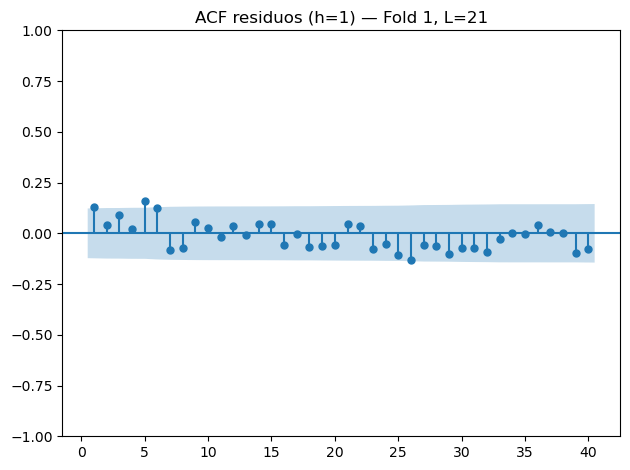

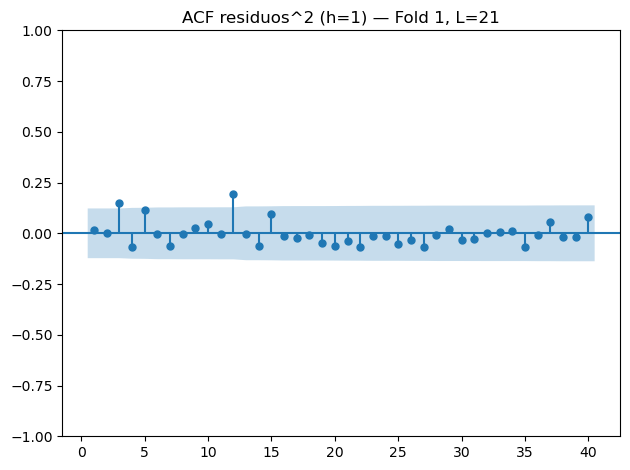

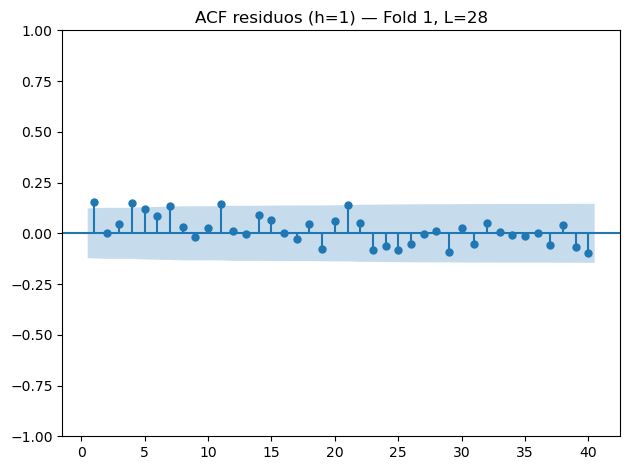

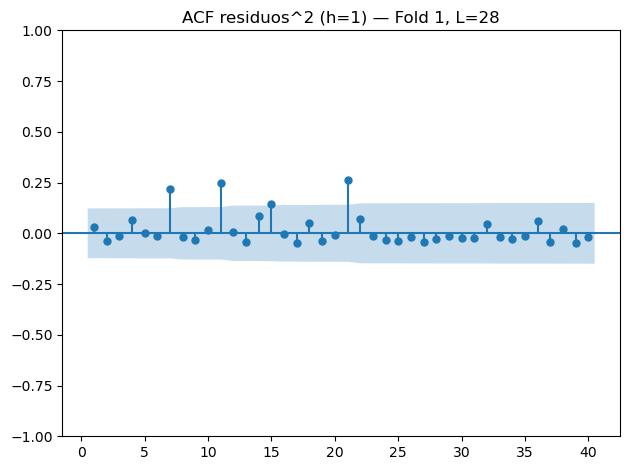

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_residual_diagnostics(y_list, yhat_list, L, figs_dir=FIGS_DIR, example_folds=1, lb_lags=40):
    """
    Dibuja residuos (h=1) y sus ACF/ACF^2 para algunos folds.
    """
    for k, (yt, yp) in enumerate(zip(y_list, yhat_list), start=1):
        if k > example_folds:
            break
        resid = yt[:, 0] - yp[:, 0]

        # Serie de residuos
        plt.figure(figsize=(9,3))
        plt.plot(resid, linewidth=1)
        plt.title(f"Residuos de TEST (h=1) — Fold {k}, L={L}")
        plt.tight_layout()
        plt.savefig(f"{figs_dir}/residuals_h1_L{L}_fold{k}.png", dpi=140)
        plt.close()

        # ACF residuos
        fig = plt.figure(figsize=(9,3))
        plot_acf(resid, lags=lb_lags, zero=False, title=f"ACF residuos (h=1) — Fold {k}, L={L}")
        plt.tight_layout()
        fig.savefig(f"{figs_dir}/acf_resid_h1_L{L}_fold{k}.png", dpi=140)
        plt.close(fig)

        # ACF residuos^2 (heterocedasticidad)
        fig2 = plt.figure(figsize=(9,3))
        plot_acf(resid**2, lags=lb_lags, zero=False, title=f"ACF residuos^2 (h=1) — Fold {k}, L={L}")
        plt.tight_layout()
        fig2.savefig(f"{figs_dir}/acf_resid2_h1_L{L}_fold{k}.png", dpi=140)
        plt.close(fig2)

# Generar algunos gráficos de diagnóstico (primer fold por L)
for L in lags_list:
    y_test_list = results_by_L[L]["y_test_list"]
    y_pred_list = results_by_L[L]["y_pred_list"]
    plot_residual_diagnostics(y_test_list, y_pred_list, L, example_folds=1)

print("✔️ Diagnóstico de residuos (gráficas) generado para el primer fold de cada L.")


In [30]:
df_master = pd.DataFrame(metrics_rows_master).sort_values("L").reset_index(drop=True)

def fmt(m, s):
    return f"{m:.6f} ± {s:.6f}"

tabla_maestra = pd.DataFrame({
    "L": df_master["L"],
    "MAPE_avg (mean±std)": [fmt(m, s) for m, s in zip(df_master["MAPE_avg_mean"], df_master["MAPE_avg_std"])],
    "MAE_avg  (mean±std)": [fmt(m, s) for m, s in zip(df_master["MAE_avg_mean"],  df_master["MAE_avg_std"])],
    "MSE_avg  (mean±std)": [fmt(m, s) for m, s in zip(df_master["MSE_avg_mean"],  df_master["MSE_avg_std"])],
    "RMSE_avg (mean±std)": [fmt(m, s) for m, s in zip(df_master["RMSE_avg_mean"], df_master["RMSE_avg_std"])],
    "BDS_pvalue_h1_mean":  [f"{v:.6f}" for v in df_master["BDS_pvalue_h1_mean"]]
})

display(tabla_maestra)
df_master.to_csv(f"{RESULTS_DIR}/summary_by_L_raw.csv", index=False)
tabla_maestra.to_csv(f"{RESULTS_DIR}/summary_by_L_formatted.csv", index=False)

print("✔️ Tablas maestras guardadas en results/.")


,L,MAPE_avg (mean±std),MAE_avg (mean±std),MSE_avg (mean±std),RMSE_avg (mean±std),BDS_pvalue_h1_mean
0,7,12.201860 ± 5.049797,0.015903 ± 0.000913,0.000461 ± 0.000108,0.021338 ± 0.002406,nan
1,14,13.418684 ± 6.239213,0.015630 ± 0.000893,0.000453 ± 0.000107,0.021148 ± 0.002373,nan
2,21,12.413427 ± 5.820477,0.015545 ± 0.000546,0.000456 ± 0.000107,0.021240 ± 0.002368,nan
3,28,13.378462 ± 7.717606,0.015685 ± 0.000324,0.000454 ± 0.000075,0.021240 ± 0.001741,nan


✔️ Tablas maestras guardadas en results/.
